### Figures and Relevant Performances for Thesis

In [1]:
#Loading relevant libraries
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import GridSearchCV
import shap
import numpy.linalg as la
from matplotlib.backends.backend_pdf import PdfPages

#Loading the dataset
df = pd.read_csv("Final_CPS_dataset(30-04-2024_new).csv")
df.head()
print(df.shape)

(304814, 20)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304814 entries, 0 to 304813
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       304814 non-null  int64  
 1   race                      304814 non-null  int64  
 2   sex                       304814 non-null  int64  
 3   region                    304814 non-null  int64  
 4   marst                     304814 non-null  int64  
 5   nativity                  304814 non-null  float64
 6   classwkr                  304814 non-null  int64  
 7   annhrs                    304814 non-null  int64  
 8   metro                     304814 non-null  float64
 9   wkswork1                  304814 non-null  int64  
 10  ft                        304814 non-null  int64  
 11  uhrswork                  304814 non-null  int64  
 12  occupation_category_1990  304814 non-null  int64  
 13  industry_category_1990    304814 non-null  i

In [12]:
print(df['incWage_2023_inflated'].min())
print(df['incWage_2023_inflated'].max())

4531.951595159515
153054.57435897435


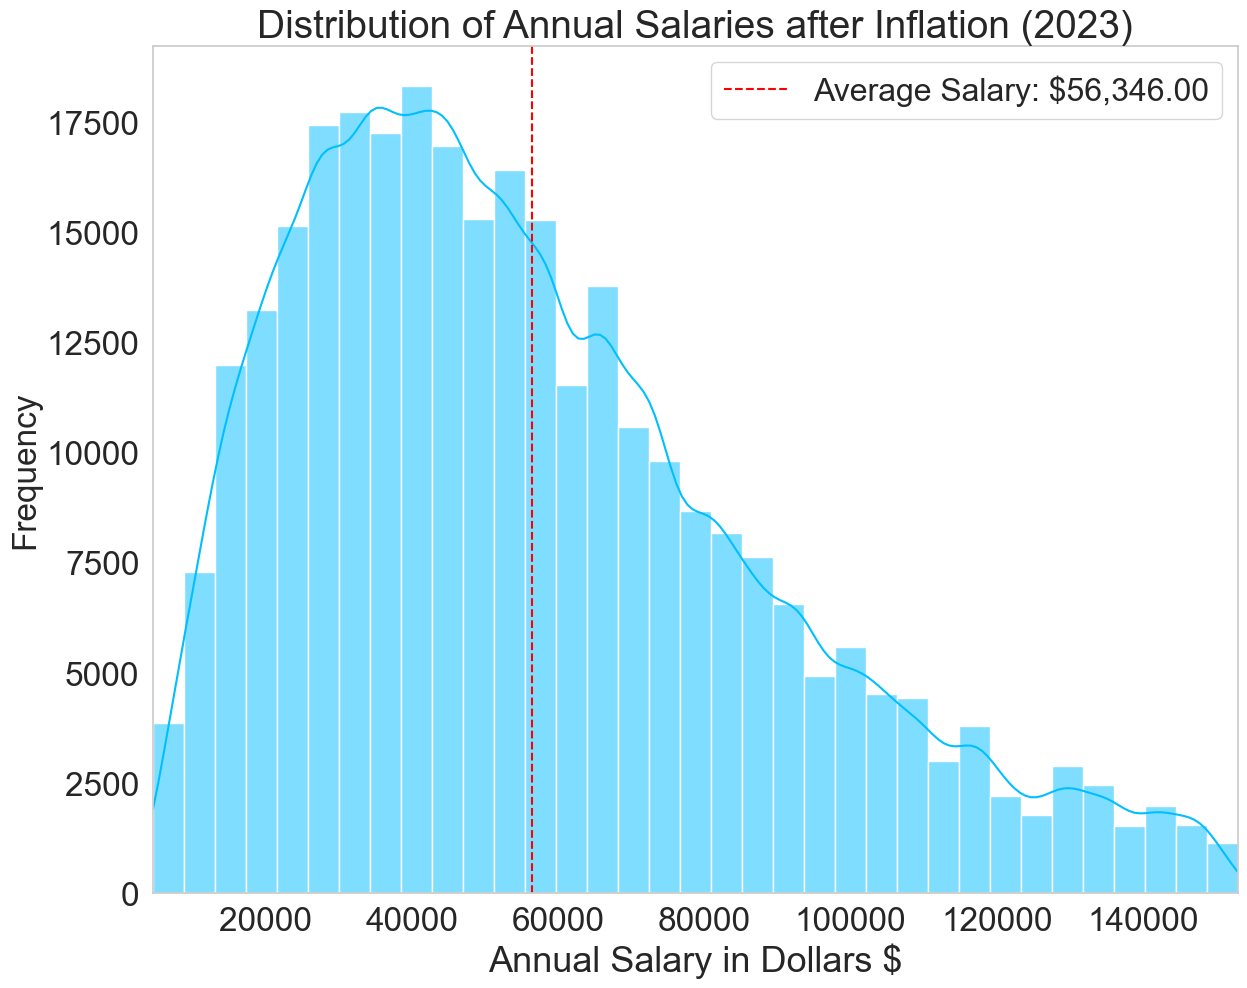

In [4]:
# Calculate the mean
mean_salary = round(df['incWage_2023_inflated'].mean())

# Plotting the histogram with mean
sns.set(style="whitegrid")
plt.figure(figsize=(14, 11))
sns.histplot(df['incWage_2023_inflated'], kde=True, color="deepskyblue", bins=35)
plt.axvline(x=mean_salary, color='red', linestyle='--', label='Average Salary: ${:,.2f}'.format(mean_salary))
plt.title('Distribution of Annual Salaries after Inflation (2023)',fontsize=28)
plt.xlabel('Annual Salary in Dollars $',fontsize=26)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.ylabel('Frequency',fontsize=24)
plt.xlim(4500, 153000)
plt.grid(False)
plt.legend(fontsize=23)
plt.savefig('Distribution of Annual Salaries after Inflation (2023).pdf', dpi=500)
plt.show()


In [2]:

mean_salary_male = round(df[df['sex'] == 1]['incWage_2023_inflated'].mean())
mean_salary_female = round(df[df['sex'] == 2]['incWage_2023_inflated'].mean())
print(mean_salary_male)
print(mean_salary_female)


64594
47877


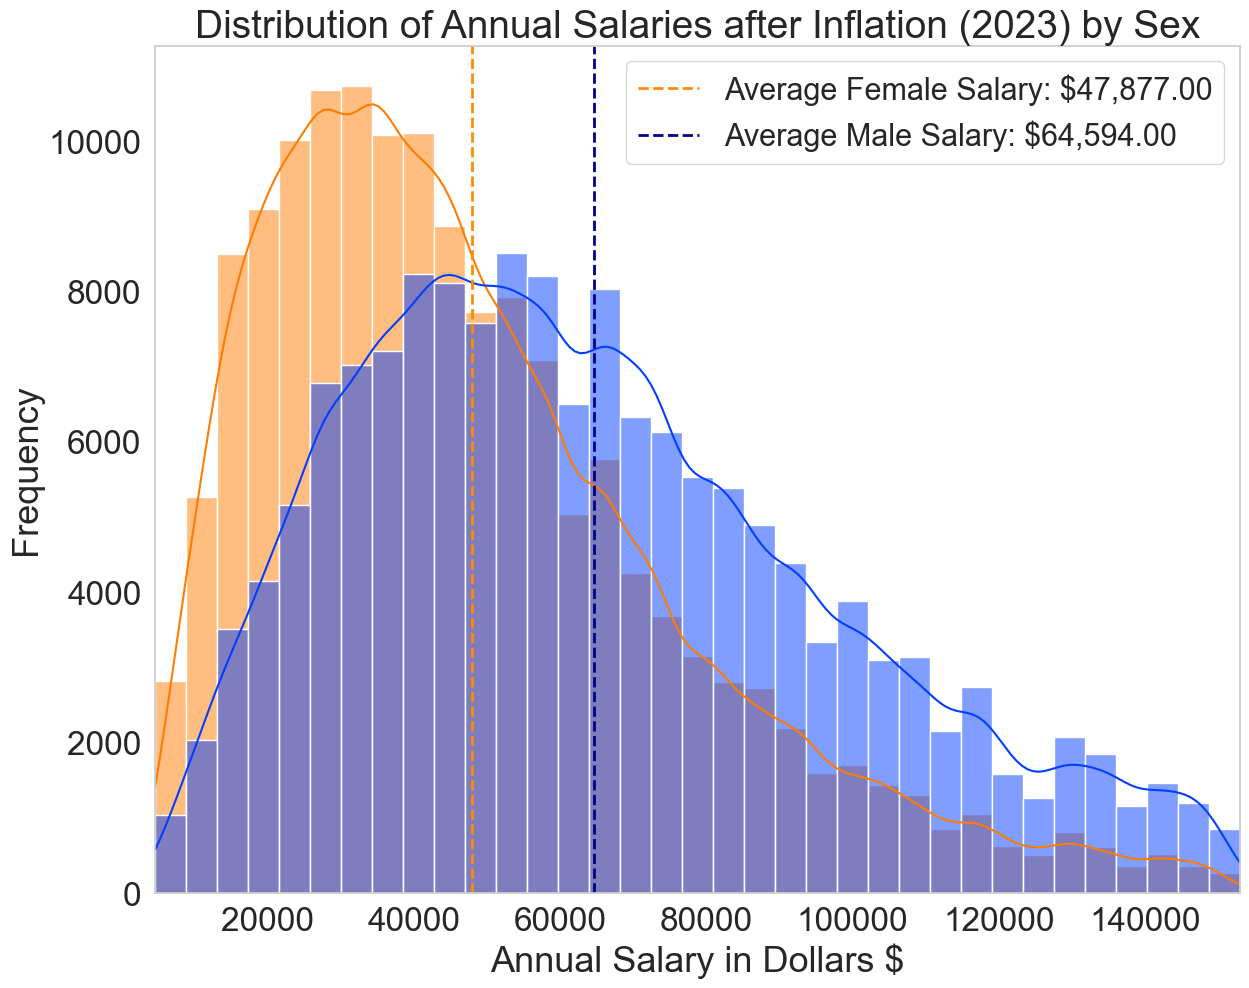

In [5]:
bright_palette = sns.color_palette('bright')

plt.figure(figsize=(14, 11))
sns.histplot(data=df, x='incWage_2023_inflated', hue='sex', kde=True, palette='bright', bins=35)
plt.title('Distribution of Annual Salaries after Inflation (2023) by Sex', fontsize = 28)
plt.xlabel('Annual Salary in Dollars $', fontsize = 26)
plt.ylabel('Frequency', fontsize = 26)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.axvline(x=mean_salary_female, color='darkorange', linestyle='--', linewidth=2, label='Average Female Salary: ${:,.2f}'.format(mean_salary_female))
plt.axvline(x=mean_salary_male, color='darkblue', linestyle='--', linewidth=2, label='Average Male Salary: ${:,.2f}'.format(mean_salary_male))
plt.grid(False)
plt.xlim(4500, 153000)
plt.legend(fontsize = 22)
plt.savefig('Distribution of Annual Salaries after Inflation By Sex (2023).pdf', dpi=500)

plt.show()


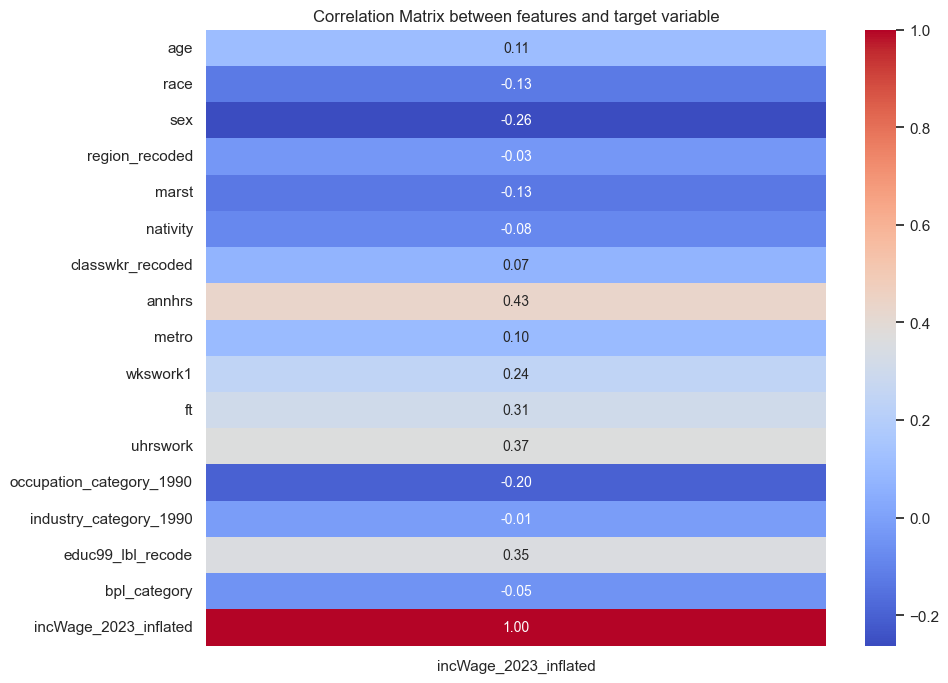

In [18]:
df_corr_matrix = df[['age', 'race', 'sex', 'region_recoded', 'marst', 'nativity', 'classwkr_recoded', 'annhrs', 'metro', 'wkswork1', 'ft', 'uhrswork', 
                    'occupation_category_1990', 'industry_category_1990', 'educ99_lbl_recode', 'bpl_category','incWage_2023_inflated']]

correlation_matrix = df_corr_matrix.corr()
target_correlation = correlation_matrix['incWage_2023_inflated']

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 10})
plt.title('Correlation Matrix between features and target variable')
plt.show()


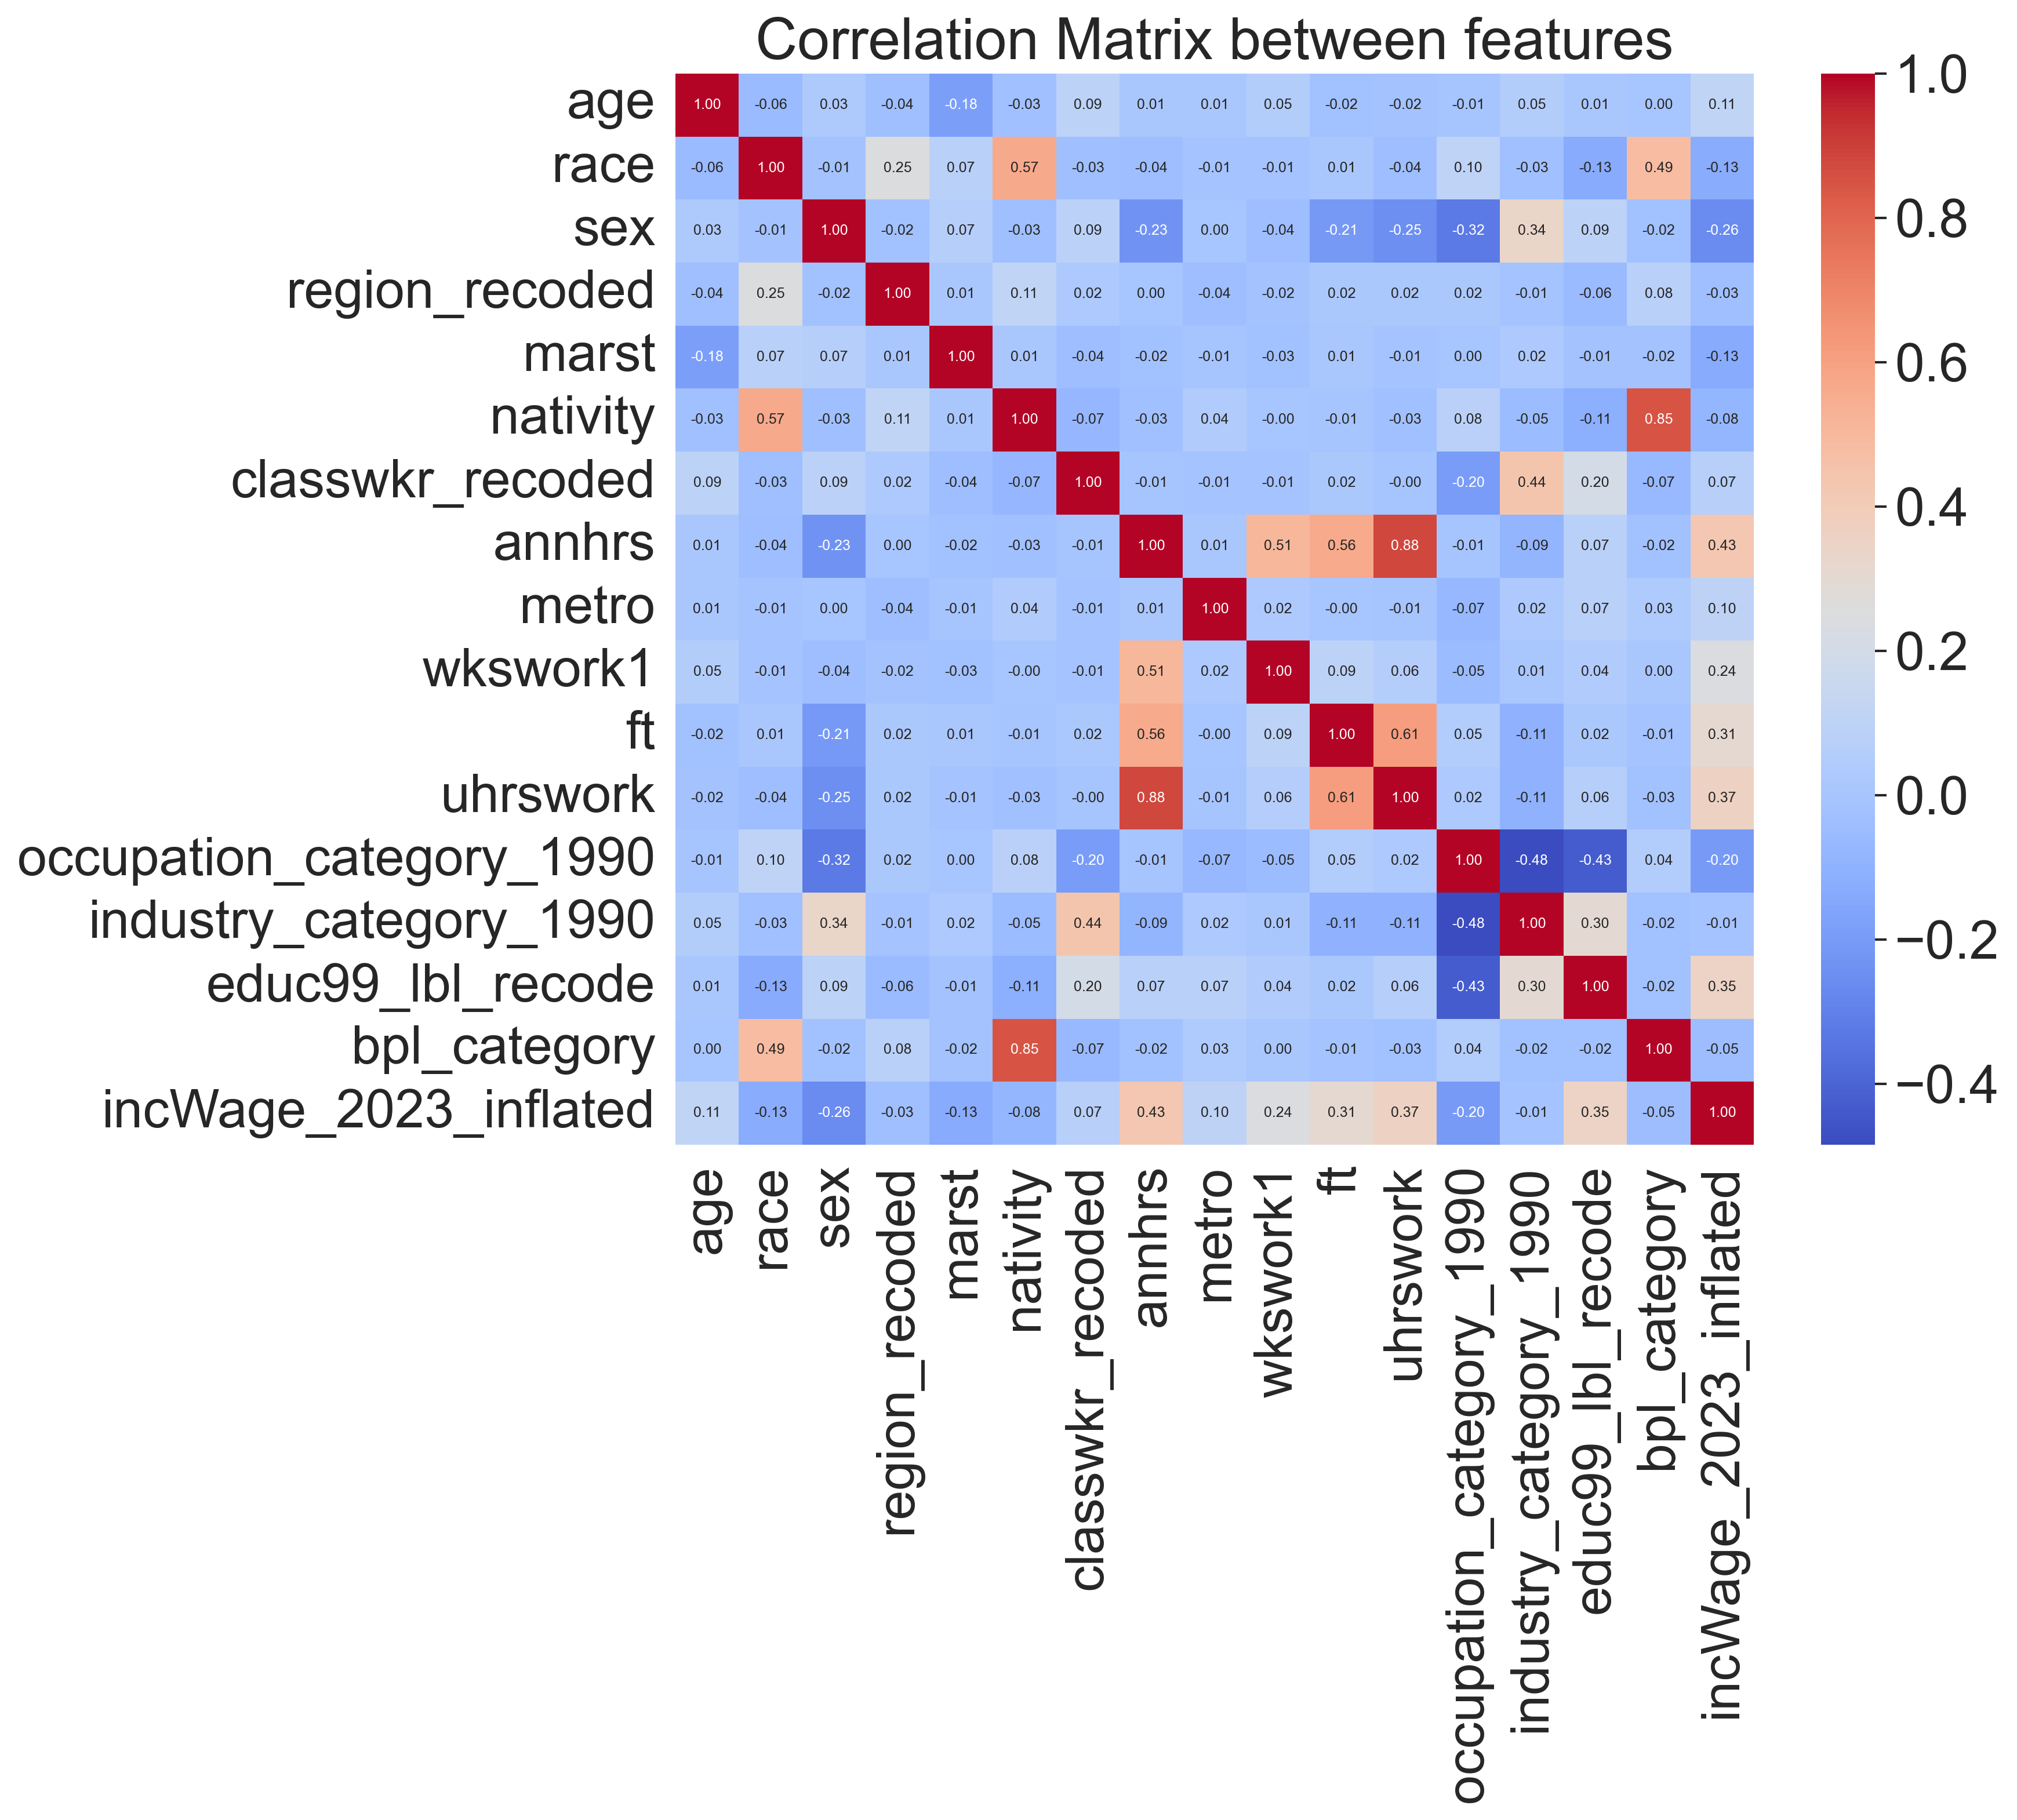

In [3]:
df_corr_matrix = df[['age','race', 'sex', 'region_recoded', 'marst', 'nativity', 'classwkr_recoded','annhrs', 'metro', 'wkswork1', 'ft', 'uhrswork', 
    'occupation_category_1990', 'industry_category_1990', 'educ99_lbl_recode', 'bpl_category',
    'incWage_2023_inflated']]


correlation_matrix = df_corr_matrix.corr()

plt.figure(figsize=(10, 8), dpi=300) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})
plt.title('Correlation Matrix between features')
plt.show()

### Uncovering Implicit Bias

In [2]:
sns.set()
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=2.5, rc=paper_rc)

In [3]:
"""Sigmoid transfer function"""
def sigmoid(A, l=1, h=0):
    return 1.0 / (1.0 + np.exp(-l*(A-h)))

"""Hyperbolic transfer function"""
def hyperbolic(A):
    return np.tanh(A)

"""Rescaled transfer function"""
def rescaled(A):
    if la.norm(A)==0.0:
        return np.zeros(A.shape)
    else:
        return A / la.norm(A)

"""Recurrent reasoning process"""
def reasoning(W, A, T=50, phi=0.8, plot=True, indexes=[0,12], case="age", function=rescaled):
    
    states = np.zeros([len(A), T, len(W)])
    states[:,0,:] = A
    
    for t in range(1,T):
        A = states[:,t,:] = (phi * function(np.matmul(A, W)) + (1-phi) * states[:,0,:])

    if plot:
        
        plt.figure(figsize=(6,4))
        
        for idx in indexes:
            for i in range(len(states)):
                val = plt.plot(states[i,:,idx], label=names[idx], marker='o')

                plt.xlabel(r'$t$', fontsize=14)
                plt.ylabel(r'$a_i^{(t)}$', fontsize=14)
                plt.ylim(0, 0.35)
        
        ax = plt.gca()
        ax.xaxis.get_major_locator().set_params(integer=True)
        plt.legend(loc='best')
        plt.margins(x=0)
        plt.show()        
    
        return A
    else:
        return states

In [4]:
# Read the CSV file
df = abs(pd.read_csv('(30-04-2024)_correlation_matrix_CPS_values.csv'))
print(df.columns)
# Convert DataFrame to NumPy array and reshape it
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

# Get the column names
names = df.columns.tolist()


Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16'],
      dtype='object')


### Scenario analysis - bias against Sex

C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_70040\72817931.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)
C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_70040\72817931.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)


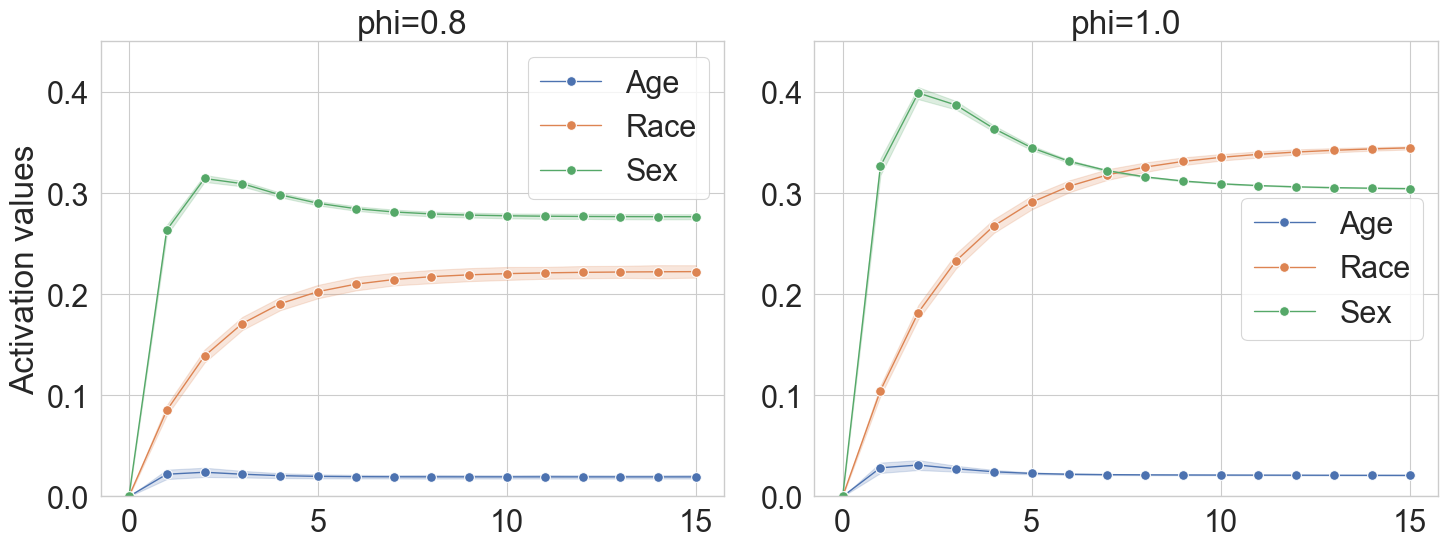

In [17]:
# Define the variable case
case = "Sex"
phi_values = [0.8, 1.0]
fig, ax= plt.subplots(1, 2, figsize=(15, 6))
grid = [ax[0], ax[1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f6 = np.random.uniform(0.0,1.0)
        f7 = np.random.uniform(0.0,1.0)
        f8 = np.random.uniform(0.0,1.0)
        f11 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, f6, f7,f8, 0, 0, f11, 0, 0, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=16, plot=False)
        #11/12 or 13/14
        data_age = state[0,:,0]
        data_race = state[0,:,11]
        data_gender = state[0,:,13]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_race))
        df2["value"] = data_race.tolist()
        df2["feature"] = "Race"
        
        df3 = pd.DataFrame(columns=["var","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Sex"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.45])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.45)
    
    fig.tight_layout()
    if i == 0:  # Only set ylabel for the first subplot
        grid[i].set_ylabel('Activation values')
    plt.savefig('sex(30-04-2024).pdf', dpi = 300)


### Scenario analysis - bias against Race

C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_70040\158672804.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)
C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_70040\158672804.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)


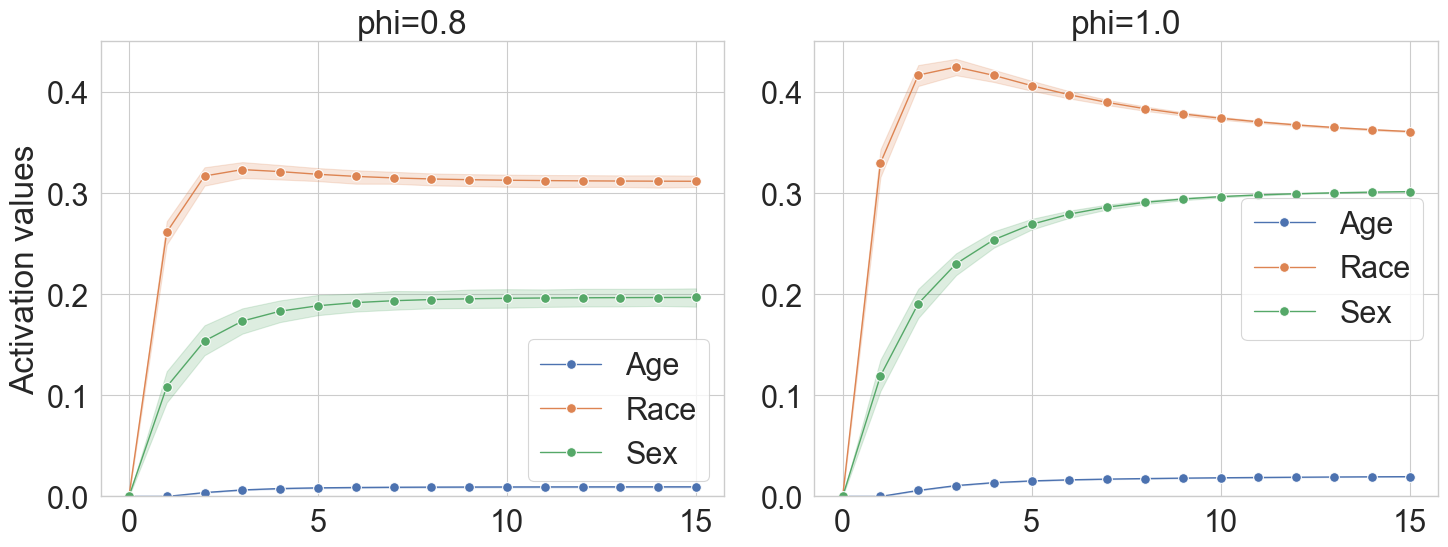

In [16]:
case = "Race"
phi_values = [0.8, 1.0]
fig, ax= plt.subplots(1, 2, figsize=(15, 6))
grid = [ax[0], ax[1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):
        
        f3 = np.random.uniform(0.0,1.0)
        f5 = np.random.uniform(0.0,1.0)
        f9 = np.random.uniform(0.0,1.0)
        f10 = np.random.uniform(0.0,1.0)
        f11 = np.random.uniform(0.0,1.0)
        f13 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, f3, 0, f5, 0, 0, 0,f9, f10, f11, 0, f13, 0, 0, 0]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=16, plot=False)

        data_age = state[0,:,0]
        data_race = state[0,:,11]
        data_gender = state[0,:,13]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_race))
        df2["value"] = data_race.tolist()
        df2["feature"] = "Race"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Sex"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.45])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.45)
    
    fig.tight_layout()
    if i == 0:  # Only set ylabel for the first subplot
        grid[i].set_ylabel('Activation values')
    plt.savefig('race(30-04-2024).pdf', dpi = 300)

### Scenario analysis - bias against Age

C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_123968\1393971253.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)
C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_123968\1393971253.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df1,df2,df3], ignore_index=True)


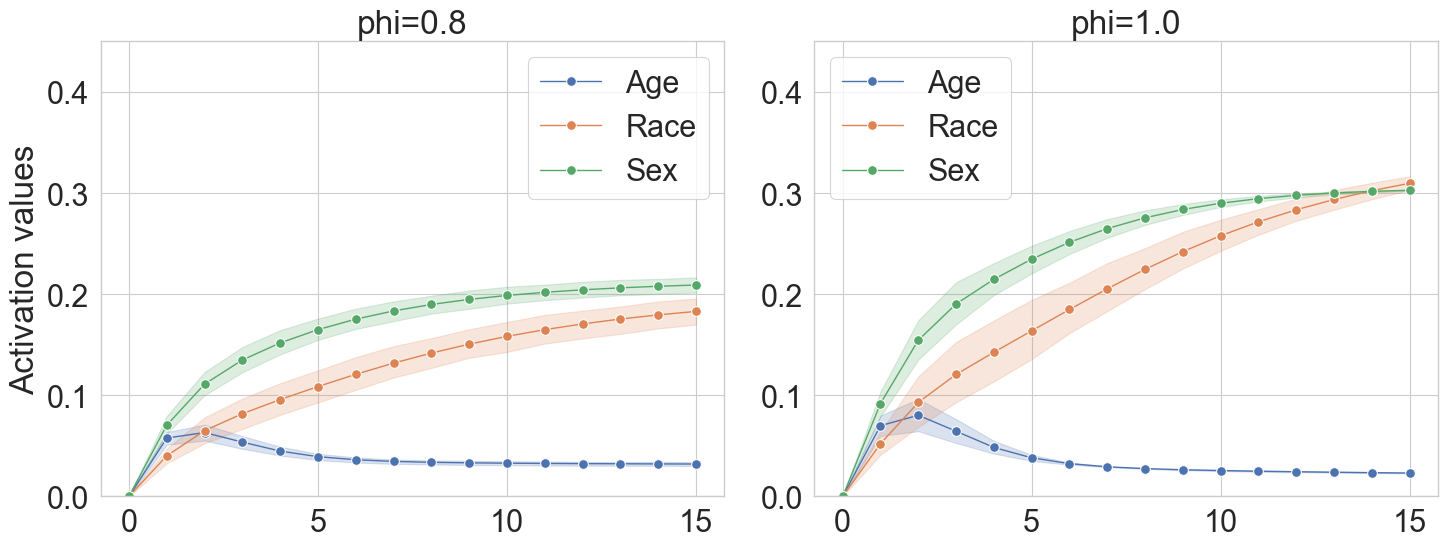

In [8]:
case = "Age"
phi_values = [0.8, 1.0]
fig, ax= plt.subplots(1, 2, figsize=(15, 6))
grid = [ax[0], ax[1]]

for i in range(len(phi_values)):
    
    df = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(20):

        f8 = np.random.uniform(0.0,1.0)
        f15 = np.random.uniform(0.0,1.0)
        f16 = np.random.uniform(0.0,1.0)
        
        A = np.array([[0, 0, 0, 0, 0, 0, 0, f8, 0, 0, 0, 0, 0, 0, f15, f16]])
        
        state = reasoning(W0, A, phi=phi_values[i], T=16, plot=False)

        data_age = state[0,:,0]
        data_race = state[0,:,11]
        data_gender = state[0,:,13]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_age))
        df1["value"] = data_age.tolist()
        df1["feature"] = "Age"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_race))
        df2["value"] = data_race.tolist()
        df2["feature"] = "Race"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_gender))
        df3["value"] = data_gender.tolist()
        df3["feature"] = "Sex"
        
        df = pd.concat([df,df1,df2,df3], ignore_index=True)
    
    ax1 = sns.lineplot(data=df, x="iteration", y="value", hue="feature", ax=grid[i], marker='o')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    
    grid[i].set_title('phi=' + str(phi_values[i]))
    grid[i].set_ylabel(None)
    grid[i].set_xlabel(None)
    
    grid[i].set_ylim([0, 0.45])
    grid[i].legend(loc='best')
    plt.ylim(0, 0.45)
    
    fig.tight_layout()
    if i == 0:  # Only set ylabel for the first subplot
        grid[i].set_ylabel('Activation values')
    # plt.savefig('age(30-04-2024).pdf', dpi = 300)

### Explicit Bias

##### Results SHAP (Feature Importance / Explicit Bias measure) on Best Model (XGBoost) on Full Training set (Training + Validation)

Based on the Shap mean values output, we expect that the model is explicitly biased since the feature 'sex' is an important feature to determine the amount of the annual salary. Furthermore, as the seventh most important feature, age also has some influence on the amount of salary. Therefore, it can be concluded that based on the CPS dataset, the XGBoost model is explicitly biased, since the protected feature 'sex' & 'age' are feature which are important for determining individuals their salary, which can eventually lead to discriminatory outcomes since it is prohibited to disfavour individuals based on these attributes. 

In [2]:
# Define the features (X) and target variable (y)
X = df[['age','race', 'sex', 'region_recoded', 'marst', 'nativity', 'classwkr_recoded','annhrs', 'metro', 'wkswork1', 'ft', 'uhrswork', 
    'occupation_category_1990', 'industry_category_1990', 'educ99_lbl_recode', 'bpl_category']]

y = df['incWage_2023_inflated']


# Split the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=107)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/8, random_state=107)  # 10% of total data for validation

#### Baseline Performance of all models

In [12]:
linear_model = LinearRegression()

linear_model.fit(X_train_val, y_train_val)

linear_y_pred = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r_squared = r2_score(y_test, linear_y_pred)

print("Base Linear Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", linear_rmse)
print("R-squared on the testing set:", linear_r_squared)

xgb_model = XGBRegressor(random_state=107)

xgb_model.fit(X_train_val, y_train_val)

xgb_y_pred = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r_squared = r2_score(y_test, xgb_y_pred)

print("\nBase XGBoost Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse)
print("R-squared on the testing set:", xgb_r_squared)

rf_model = RandomForestRegressor(random_state=107)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r_squared = r2_score(y_test, rf_y_pred)

print("\nBase Random Forest Regression model:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse)
print("R-squared on the testing set:", rf_r_squared)

Base Linear Regression model:
Root Mean Squared Error (RMSE) on the testing set: 24680.95616398952
R-squared on the testing set: 0.39701108024541454

Base XGBoost Regression model:
Root Mean Squared Error (RMSE) on the testing set: 21869.24973476549
R-squared on the testing set: 0.5265728735834914


#### Performance of all models on combined training data

In [13]:
#Trained on all training data (Train + Val)

linear_model_full = LinearRegression()


linear_model_full.fit(X_train_val, y_train_val)


linear_y_pred_full = linear_model_full.predict(X_test)


linear_mse_full = mean_squared_error(y_test, linear_y_pred_full)
linear_rmse_full = np.sqrt(linear_mse_full)

print("Linear Regression Full Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", linear_rmse_full)

xgb_model_full = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)


xgb_model_full.fit(X_train_val, y_train_val)


xgb_y_pred_full = xgb_model_full.predict(X_test)


xgb_mse_full = mean_squared_error(y_test, xgb_y_pred_full)
xgb_rmse_full = np.sqrt(xgb_mse_full)

print("\nXGBoost Regression Full training Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse_full)

rf_model_full = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)


rf_model_full.fit(X_train_val, y_train_val)


rf_y_pred_full = rf_model_full.predict(X_test)


rf_mse_full = mean_squared_error(y_test, rf_y_pred_full)
rf_rmse_full = np.sqrt(rf_mse_full)

print("\nRandom Forest Regression Full Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse_full)


Linear Regression Full Data:
Root Mean Squared Error (RMSE) on the testing set: 24680.95616398952

XGBoost Regression Full training Data:
Root Mean Squared Error (RMSE) on the testing set: 21771.859251566726


#### Cross-Validation for XGBoost and Linear Regression

In [60]:
linear_model = LinearRegression()


linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
linear_rmse_scores = np.sqrt(-linear_cv_scores)
linear_mean_rmse = np.mean(linear_rmse_scores)
linear_std_rmse = np.std(linear_rmse_scores)

print("Linear Regression:")
print("Mean Root Mean Squared Error (RMSE) across 5 folds:", linear_mean_rmse)
print("Standard Error of RMSE across 5 folds:", linear_std_rmse)


xgb_model = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)


xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
xgb_rmse_scores = np.sqrt(-xgb_cv_scores)
xgb_mean_rmse = np.mean(xgb_rmse_scores)
xgb_std_rmse = np.std(xgb_rmse_scores)


print("\nXGBoost Regression:")
print("Mean Root Mean Squared Error (RMSE) across 5 folds:", xgb_mean_rmse)
print("Standard Error of RMSE across 5 folds:", xgb_std_rmse)


rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse_scores = np.sqrt(-xgb_cv_scores)
rfmean_rmse = np.mean(xgb_rmse_scores)

print("\nRandom Forest Regression:")
print("Mean Root Mean Squared Error (RMSE) across 5 folds:", rfmean_rmse)


Linear Regression:
Mean Root Mean Squared Error (RMSE) across 5 folds: 24844.86970437003
Standard Error of RMSE across 5 folds: 112.31927433222403

XGBoost Regression:
Mean Root Mean Squared Error (RMSE) across 5 folds: 21924.18123766763
Standard Error of RMSE across 5 folds: 75.61982162689567


In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
train_preds = linear_model.predict(X_train)
val_preds = linear_model.predict(X_val)
test_preds = linear_model.predict(X_test)

# Calculate residuals
train_residuals = y_train - train_preds
val_residuals = y_val - val_preds
test_residuals = y_test - test_preds

# Calculate RMSE values
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Training RMSE: 24843.59367846973
Validation RMSE: 24846.506069598756
Test RMSE: 25009.872495672564


### Random Forest Performance

In [4]:
df_results_rf = pd.read_csv('(30-04-2024)_grid_search_results_rf.csv')

# # Replacing the nan for the max_depth parameter to 1.0 (Default)
df_results_rf.replace(np.nan, 1.0, inplace=True)
df_results_rf.head()

param_n_estimators  param_max_depth  param_min_samples_split  \
0                 200              1.0                        2   
1                 300              1.0                        2   
2                 500              1.0                        2   
3                 200              1.0                        5   
4                 300              1.0                        5   

   param_min_samples_leaf param_max_features  mean_test_score  
0                       1               sqrt     22997.524594  
1                       1               sqrt     22978.776676  
2                       1               sqrt     22965.079362  
3                       1               sqrt     22576.326418  
4                       1               sqrt     22563.132720

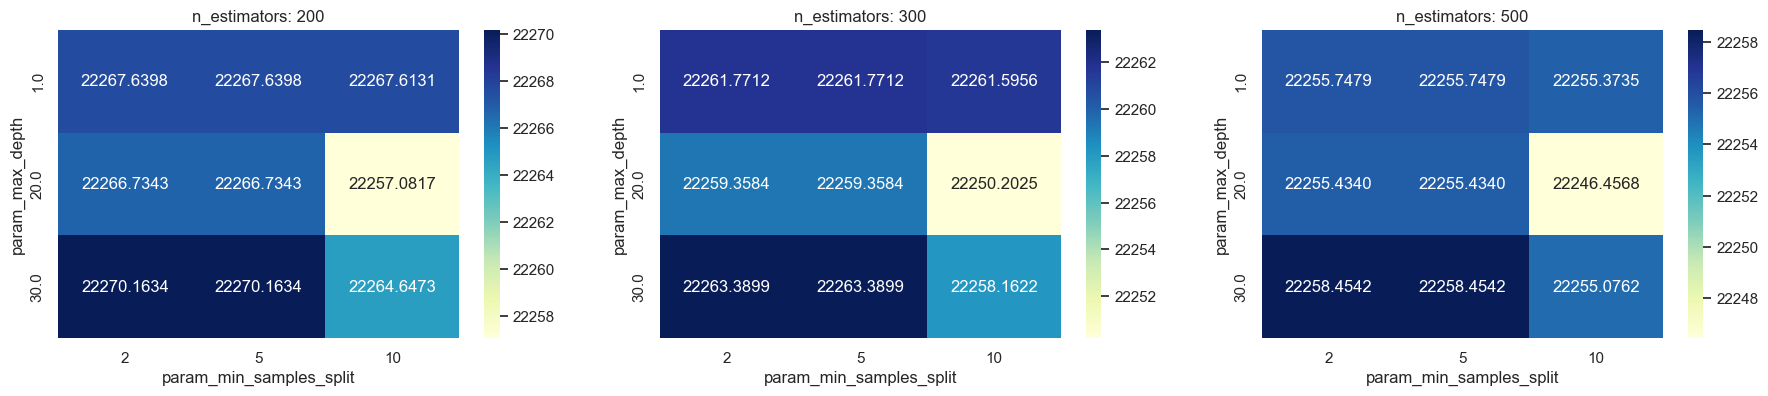

In [13]:
def plot_tuning_results(df_val):
    df_temp = df_val[:][df_val.param_n_estimators == 200].sort_values(by=['param_max_depth'])
    df_none = df_temp[:][df_temp.param_n_estimators == 200].sort_values(by=['param_max_depth'])
    df_sqrt = df_val[:][df_val.param_n_estimators == 300].sort_values(by=['param_max_depth'])
    df_log2 = df_val[:][df_val.param_n_estimators == 500].sort_values(by=['param_max_depth'])
    
    def min_rmse(values):
        return np.min(values)

    pivot1 = df_none.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score', aggfunc=min_rmse)
    pivot2 = df_sqrt.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score', aggfunc=min_rmse)
    pivot3 = df_log2.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score', aggfunc=min_rmse)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4))

    sns.heatmap(pivot1, annot=True, fmt=".4f", ax=ax1, cmap="YlGnBu", )
    sns.heatmap(pivot2, annot=True, fmt=".4f", ax=ax2, cmap="YlGnBu", )
    sns.heatmap(pivot3, annot=True, fmt=".4f", ax=ax3, cmap="YlGnBu", )
    
    ax1.set_title("n_estimators: 200")
    ax2.set_title("n_estimators: 300")
    ax3.set_title("n_estimators: 500")

plot_tuning_results(df_results_rf)
plt.savefig("Grid_search_results_Random_Forest_best_score_22246.45.jpg", dpi = 300,  bbox_inches='tight')


##### Performance of Random Forest model on Training, Validation and Testing

In [5]:

rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

cv_scores = -cv_scores

print("Cross-Validation RMSE Scores:", cv_scores)
print("Average Cross-Validation RMSE:", np.mean(cv_scores))

rf_model.fit(X_train, y_train)

train_preds = rf_model.predict(X_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

train_residuals = y_train - train_preds
val_residuals = y_val - val_preds
test_residuals = y_test - test_preds

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Cross-Validation RMSE Scores: [22154.1017527  22206.5792495  22266.56421119 22374.74473473
 22230.29383343]
Average Cross-Validation RMSE: 22246.45675630999
Training RMSE: 18991.694727437487
Validation RMSE: 22122.78640704584
Test RMSE: 22345.702815998364


In [6]:
rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

rf_model.fit(X_train, y_train)

train_preds = rf_model.predict(X_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)


train_residuals = y_train - train_preds
val_residuals = y_val - val_preds
test_residuals = y_test - test_preds

train_rmse = mean_squared_error(y_train, train_preds, squared=False)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Training RMSE: 18991.694727437487
Validation RMSE: 22122.78640704584
Test RMSE: 22345.702815998364


In [7]:
rf_model_full = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=500, random_state=107)

rf_model_full.fit(X_train_val, y_train_val)

rf_y_pred_full = rf_model_full.predict(X_test)

rf_mse_full = mean_squared_error(y_test, rf_y_pred_full)
rf_rmse_full = np.sqrt(rf_mse_full)

print("\nRandom Forest Regressor Full training Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", rf_rmse_full)


Random Forest Regressor Full training Data:
Root Mean Squared Error (RMSE) on the testing set: 22311.62650787387


#### Residuals Plot of Random Forest Model

C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_135892\720889863.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, color='blue', label='Actual Values', shade=True, ax=axs[0])
C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_135892\720889863.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rf_y_pred_full, color='red', label='Predicted Values', shade=True, ax=axs[0])


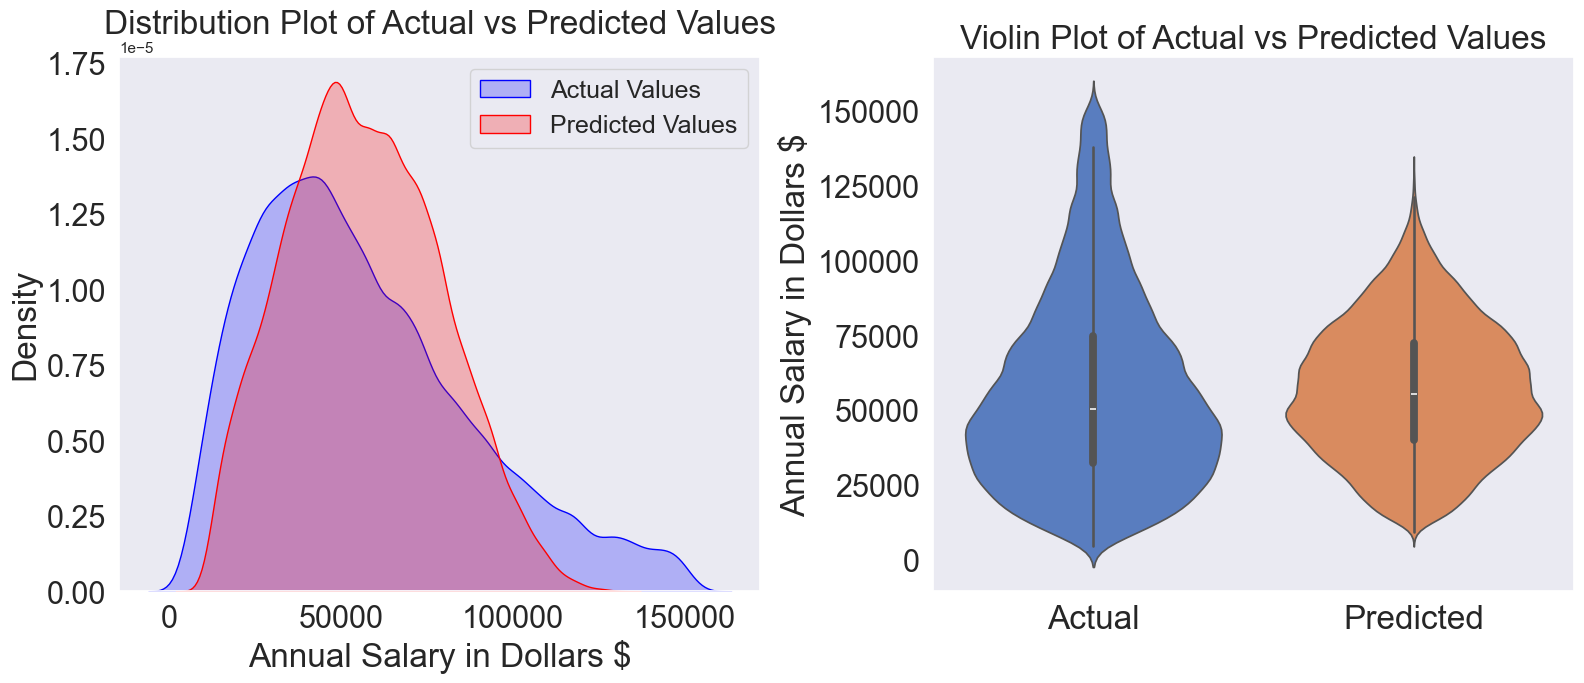

In [5]:

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

sns.kdeplot(y_test, color='blue', label='Actual Values', shade=True, ax=axs[0])
sns.kdeplot(rf_y_pred_full, color='red', label='Predicted Values', shade=True, ax=axs[0])
axs[0].set_title('Distribution Plot of Actual vs Predicted Values', fontsize = 24)
axs[0].set_xlabel('Annual Salary in Dollars $', fontsize = 24)
axs[0].set_ylabel('Density', fontsize = 24)
axs[0].tick_params(axis='x', labelsize=22)
axs[0].tick_params(axis='y', labelsize=22)
axs[0].legend(fontsize=18)
axs[0].grid(False)

sns.violinplot(data=[y_test, rf_y_pred_full], palette='muted', ax=axs[1])
axs[1].set_title('Violin Plot of Actual vs Predicted Values', fontsize = 24)
axs[1].set_ylabel('Annual Salary in Dollars $', fontsize = 24)
axs[1].set_xticks([0, 1])
axs[1].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='y', labelsize=22)
axs[1].set_xticklabels(['Actual', 'Predicted'], fontsize = 24)
axs[1].grid(False)

plt.tight_layout()
plt.show()



### Best model (XGBoost)

In [ ]:

# Define the hyperparameter grid for XGBoost

# Define your RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'learning_rate': [0.15, 0.2, 0.25],
    'n_estimators': [200, 300, 500], # higher values for n_estimator can be indication of overfitting
    'max_depth': [5,6,7],
    'min_child_weight': [2,4,6],
    'colsample_bytree': [0.5, 0.8],
}

# Create an XGBoost regressor
model = XGBRegressor(random_state=107)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
)

# Fit the GridSearchCV to your data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by Grid Search
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
test_predictions = best_model.predict(X_test)

# Calculate RMSE on the test set
test_rmse = rmse(y_test, test_predictions)

# Print RMSE on the test set
print("RMSE on test set: ", test_rmse)

Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 1, 'scale_pos_weight': 1, 'subsample': 1.0}
Best Score: -21984.49045893897
RMSE on test set:  21834.349085988786


In [3]:
df_results_xgb = pd.read_csv('(30-04-2024)_grid_search_results_xgb.csv')

In [5]:
df_results_xgb.head()

param_learning_rate  param_n_estimators  param_max_depth  \
0                 0.15                 200                5   
1                 0.15                 300                5   
2                 0.15                 500                5   
3                 0.15                 200                5   
4                 0.15                 300                5   

   param_min_child_weight  param_colsample_bytree  mean_test_score  
0                       2                     0.5     22007.345140  
1                       2                     0.5     21976.195804  
2                       2                     0.5     21958.784700  
3                       4                     0.5     22005.547658  
4                       4                     0.5     21974.345092

#### Saving the GridSearch Results of the XGBoost Model

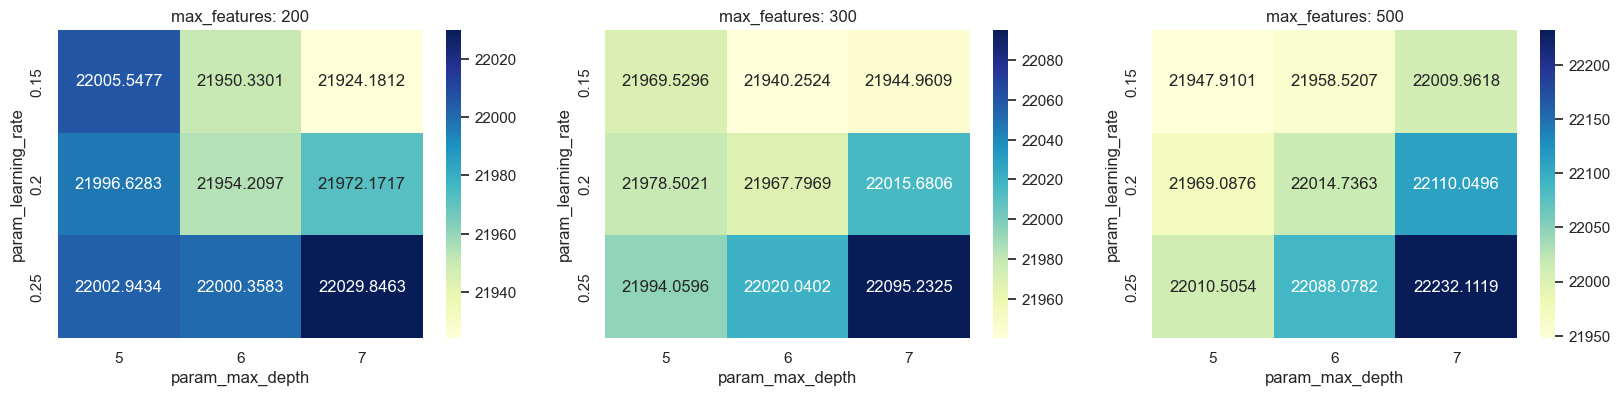

In [11]:
# Create DF of GridSearch results

def plot_tuning_results(df_val):
    df_temp = df_val[:][df_val.param_n_estimators == 200].sort_values(by=['param_learning_rate'])
    df_none = df_temp[:][df_temp.param_n_estimators == 200].sort_values(by=['param_learning_rate'])
    df_sqrt = df_val[:][df_val.param_n_estimators == 300].sort_values(by=['param_learning_rate'])
    df_log2 = df_val[:][df_val.param_n_estimators == 500].sort_values(by=['param_learning_rate'])


    def min_rmse(values):
        return np.min(values)

    pivot1 = df_none.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot2 = df_sqrt.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    pivot3 = df_log2.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=min_rmse)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    sns.heatmap(pivot1, annot=True, fmt=".4f", ax=ax1, cmap="YlGnBu", )
    sns.heatmap(pivot2, annot=True, fmt=".4f", ax=ax2, cmap="YlGnBu", )
    sns.heatmap(pivot3, annot=True, fmt=".4f", ax=ax3, cmap="YlGnBu", )
    
    ax1.set_title("max_features: 200")
    ax2.set_title("max_features: 300")
    ax3.set_title("max_features: 500")


plot_tuning_results(df_results_xgb)


##### Normalized Gridsearch combinations

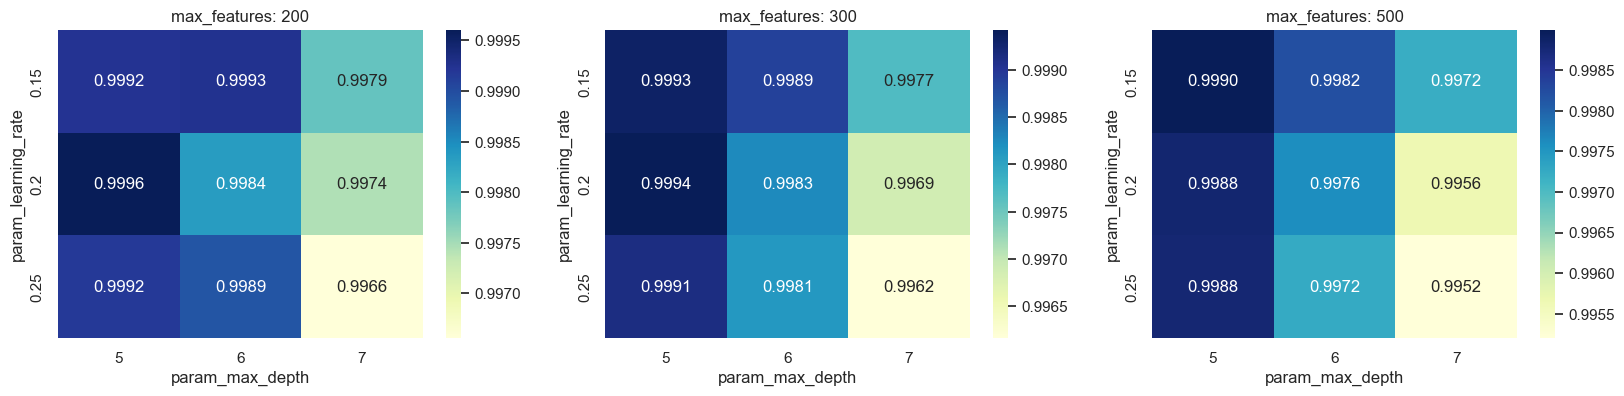

In [11]:
def plot_tuning_results(df_val):
    df_temp = df_val[:][df_val.param_n_estimators == 200].sort_values(by=['param_learning_rate'])
    df_none = df_temp[:][df_temp.param_n_estimators == 200].sort_values(by=['param_learning_rate'])
    df_sqrt = df_val[:][df_val.param_n_estimators == 300].sort_values(by=['param_learning_rate'])
    df_log2 = df_val[:][df_val.param_n_estimators == 500].sort_values(by=['param_learning_rate'])


    def normalize_values(values):
        min_rmse = np.min(values)
        normalized = min_rmse / values
        return np.min(normalized)  

    pivot1 = df_none.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=normalize_values)
    pivot2 = df_sqrt.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=normalize_values)
    pivot3 = df_log2.pivot_table(index='param_learning_rate', columns='param_max_depth', values='mean_test_score', aggfunc=normalize_values)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    sns.heatmap(pivot1, annot=True, fmt=".4f", ax=ax1, cmap="YlGnBu")
    sns.heatmap(pivot2, annot=True, fmt=".4f", ax=ax2, cmap="YlGnBu")
    sns.heatmap(pivot3, annot=True, fmt=".4f", ax=ax3, cmap="YlGnBu")
    
    ax1.set_title("max_features: 200")
    ax2.set_title("max_features: 300")
    ax3.set_title("max_features: 500")


plot_tuning_results(df_results_xgb)

In [6]:

xgb_model = XGBRegressor(
    learning_rate=0.15,
    n_estimators=200,
    max_depth=7,
    min_child_weight=2,
    colsample_bytree=0.5,
    random_state=107
    stratify =y
)

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

cv_scores = -cv_scores

print("Cross-Validation RMSE Scores:", cv_scores)
print("Average Cross-Validation RMSE:", np.mean(cv_scores))

xgb_model.fit(X_train, y_train)

train_preds = xgb_model.predict(X_train)
val_preds = xgb_model.predict(X_val)
test_preds = xgb_model.predict(X_test)

# Calculate residuals
train_residuals = y_train - train_preds
val_residuals = y_val - val_preds
test_residuals = y_test - test_preds

# Calculate RMSE values
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)

Cross-Validation RMSE Scores: [21793.45532271 21953.97690759 21944.21175804 22023.54262627
 21905.71957372]
Average Cross-Validation RMSE: 21924.18123766763
Training RMSE: 20964.08981630066
Validation RMSE: 21809.152848053796
Test RMSE: 22082.478741712897


In [11]:
xgb_model_full = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)

xgb_model_full.fit(X_train_val, y_train_val)


xgb_y_pred_full = xgb_model_full.predict(X_test)

xgb_mse_full = mean_squared_error(y_test, xgb_y_pred_full)
xgb_rmse_full = np.sqrt(xgb_mse_full)

print("\nXGBoost Regression Full training Data:")
print("Root Mean Squared Error (RMSE) on the testing set:", xgb_rmse_full)


XGBoost Regression Full training Data:
Root Mean Squared Error (RMSE) on the testing set: 22055.495919303645


C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_28304\1169381032.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, color='blue', label='Actual Values', shade=True)
C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_28304\1169381032.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(xgb_y_pred_full, color='red', label='Predicted Values', shade=True)


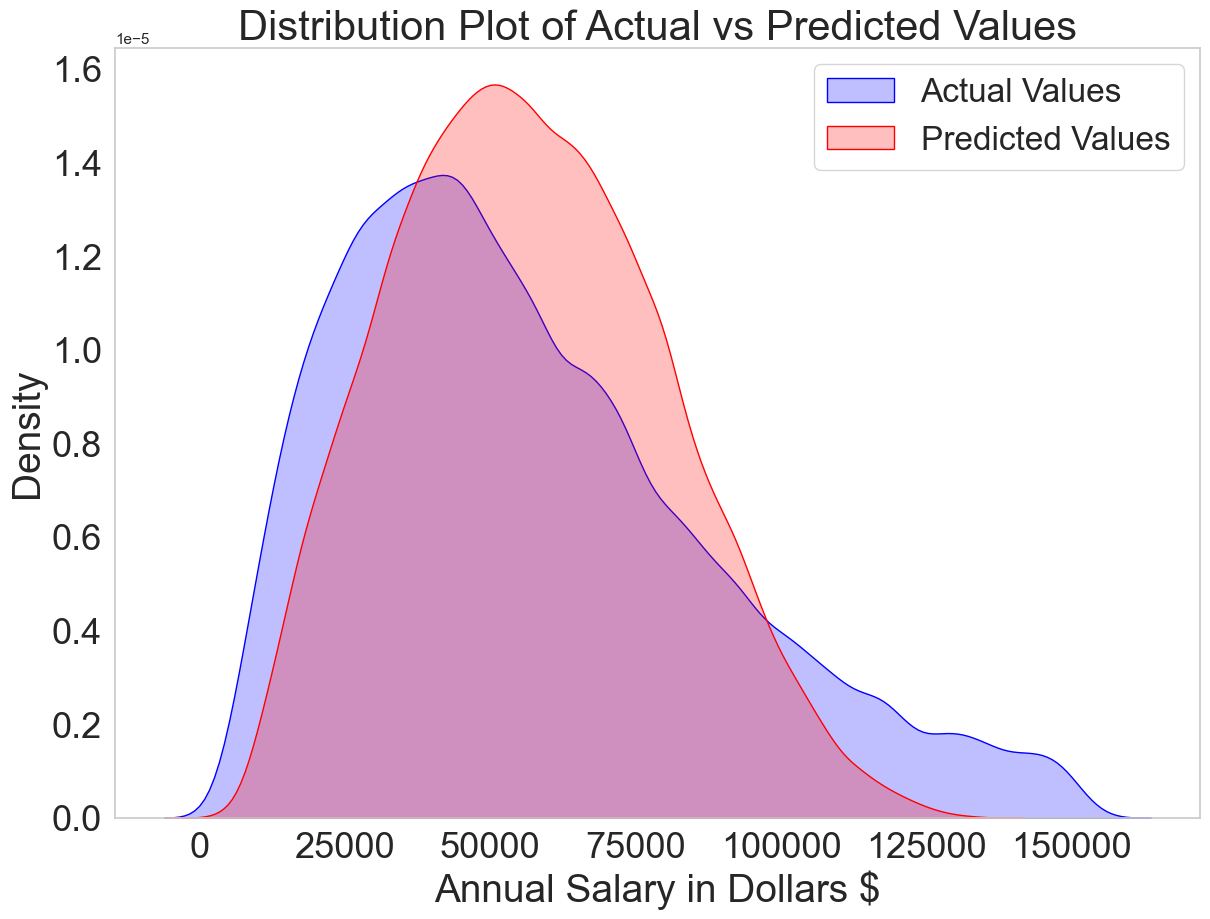

In [16]:

# Distribution Plot
plt.figure(figsize=(14, 10)) 
sns.kdeplot(y_test, color='blue', label='Actual Values', shade=True)
sns.kdeplot(xgb_y_pred_full, color='red', label='Predicted Values', shade=True)
plt.title('Distribution Plot of Actual vs Predicted Values', fontsize=30)
plt.xlabel('Annual Salary in Dollars $', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.tick_params(axis='x', labelsize=26)
plt.tick_params(axis='y', labelsize=26)
plt.legend(fontsize=24)
plt.grid(False)


plt.savefig("Actual_vs_predicted_distributionplot.pdf", dpi=300)

plt.show()



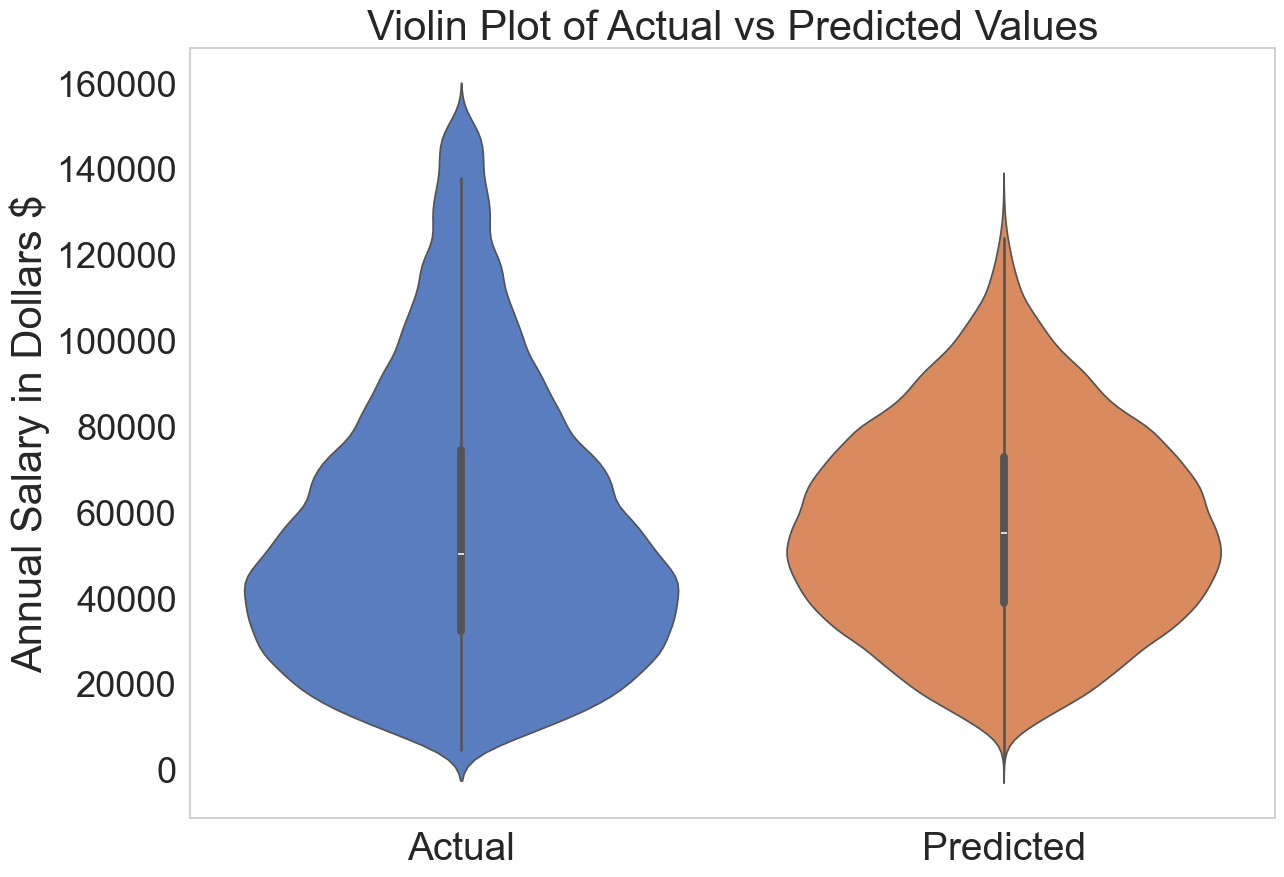

In [13]:
plt.figure(figsize=(14, 10)) 
sns.violinplot(data=[y_test, xgb_y_pred_full], palette='muted')
plt.title('Violin Plot of Actual vs Predicted Values', fontsize=30)
plt.ylabel('Annual Salary in Dollars $', fontsize=30)
plt.xticks([0, 1])
plt.tick_params(axis='x', labelsize=26)
plt.tick_params(axis='y', labelsize=26)
plt.xticks([0, 1], ['Actual', 'Predicted'], fontsize=28)
plt.grid(False)

plt.savefig("Actual_vs_predicted_violinplot.pdf", dpi=300)

plt.show()

In [3]:

xgb_model = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state = 107)
xgb_model.fit(X_train_val, y_train_val)

# Use SHAP to explain the model's predictions
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)



In [21]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Get the current figure
fig = plt.gcf()

fig.set_dpi(1200)

with PdfPages('shap_summary_plot.pdf') as pdf:
    # Add the figure to the PDF
    pdf.savefig(fig)

sns.set(style="whitegrid")

plt.show()


In [4]:
columns_to_convert = ['race', 'sex', 'region_recoded', 'marst', 'nativity', 'classwkr_recoded', 'metro', 'ft', 'occupation_category_1990', 'industry_category_1990', 'educ99_lbl_recode', 'bpl_category']

X[columns_to_convert] = X[columns_to_convert].astype('object')

X.info()

C:\Users\Tijl WIjnen\AppData\Local\Temp\ipykernel_63040\1752377855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[columns_to_convert] = X[columns_to_convert].astype('object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304814 entries, 0 to 304813
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   age                       304814 non-null  int64 
 1   race                      304814 non-null  object
 2   sex                       304814 non-null  object
 3   region_recoded            304814 non-null  object
 4   marst                     304814 non-null  object
 5   nativity                  304814 non-null  object
 6   classwkr_recoded          304814 non-null  object
 7   annhrs                    304814 non-null  int64 
 8   metro                     304814 non-null  object
 9   wkswork1                  304814 non-null  int64 
 10  ft                        304814 non-null  object
 11  uhrswork                  304814 non-null  int64 
 12  occupation_category_1990  304814 non-null  object
 13  industry_category_1990    304814 non-null  object
 14  educ

### Performance Degradation Measure

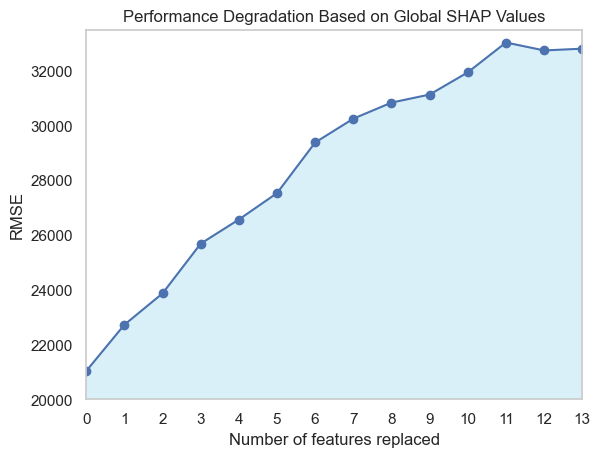

In [5]:
def evaluate_rmse(model, X, y_true):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y_true, y_pred))

xgb_model = XGBRegressor(learning_rate=0.15, n_estimators=200, max_depth=7, min_child_weight=2, colsample_bytree=0.5, random_state=107)

xgb_model.fit(X_train_val, y_train_val)


mean_shap_values = np.abs(shap_values).mean(axis=0)

# Sort features based on mean SHAP values
sorted_features = np.argsort(mean_shap_values)[::-1][:13]
X_array = X.values

rmse_values = []

# Evaluate RMSE for the full model
full_model_rmse = evaluate_rmse(xgb_model, X_train_val, y_train_val)
rmse_values.append(full_model_rmse)

# Gradually replace top features with the mean / mode and evaluate RMSE
for i in range(len(sorted_features)):
    degraded_X = X_train_val.copy() 
    for j in range(i + 1):
        col_index = sorted_features[j]
        if X_train_val.iloc[:, col_index].dtype == 'object': 
            col_mode = X_train_val.iloc[:, col_index].mode()[0]  
            degraded_X.iloc[:, col_index] = col_mode 
        else:
            col_mean = np.mean(X_train_val.iloc[:, col_index]) 

            col_mean = X_train_val.iloc[:, col_index].dtype.type(col_mean)
            degraded_X.iloc[:, col_index] = col_mean 
    
    # Evaluate RMSE
    rmse = evaluate_rmse(xgb_model, degraded_X, y_train_val)
    rmse_values.append(rmse)

sns.set_style("whitegrid")
plt.plot(range(len(sorted_features) + 1), rmse_values, marker='o')
plt.fill_between(range(len(sorted_features) + 1), rmse_values, color="skyblue", alpha=0.3)
plt.xlabel('Number of features replaced')
plt.ylabel('RMSE')
plt.ylim(20000, 33500)
plt.xticks(range(14)) 
plt.xlim(0, 13)
plt.grid(False)
plt.title('Performance Degradation Based on Global SHAP Values')
plt.savefig("pixel_flipping_experiment_shap.pdf", dpi = 300)
plt.show()

